# 103590450 四資四 馬茂源

## 系統需求
* RAM >= 30GB
* CPU >= i7 
* GPU >= GTX1060 6GB

# 問題與資料
   * 為何要分類新聞呢
       * 其實這個classification model用途，我認為不是只用來分類，是他有一些特性可以幫助人類，有幾個情境是這樣:
           * 記者寫了一篇文章，假設是國際新聞，應當放在國際新聞的版面上，但通常新聞的屬性都會overlap，有可能跟政治或商業有點相關，所以除了要放置在國際版面，在商業或是政治版面應該也可以放置，只是放置的修先度要比純商業新聞低或是純政治新聞低，這要如何找出之間的屬性比例，人太主觀，但神經網路的softmax輸出就很有用了。
           * 某news feed APP可以讓使用者客製自己想要看的取向，某位使用者喜歡看國際商業新聞(國際70%商業30%)，也就是說新聞屬性要國際也要商業，如果單純從網路新聞來搜尋衛報國際新聞一遍再搜尋商業新聞一遍，再找出有沒有相同的新聞，比例怎檢測，實在是很痛苦，這時候就需要ML model了。
           
   * 其實我從大二開始就一直在玩這個data set，但之前只是用邏輯回歸或MLP搭配TF-IDF去做，有效精準度大概都在86%~88%，而且那時候data set大小大概才20W筆，用這種簡單的抽象化會有一個嚴重的問題，當你的data set變大時(等於你資料複雜度增加)，精準度會降低(代表這抽象化會損失很多語意特徵)，像這次我重新收集的data set(50W)用之前的方法，精準度就降低到7X%。
    
    而這次我用[GloVe](https://nlp.stanford.edu/projects/glove/) embeddings來抽象化資料，是一種word embedding的技術，把word vector map到一個比較小的維度，可用來表示詞對詞之間的關係，等等我會把GloVe嵌進我的CNN的第一個layer。
    

   * (請務必註明資料來源、以及要解決問題):
       * 資料的部分我使用**我自己寫**的[python爬蟲框架(滿厲害的，可以支援async跟multithread)](https://github.com/brian41005/pycheetah)來蒐集[英國衛報](https://www.theguardian.com/international)的網路新聞
       * 解決問題:我這次要把有效精準度飆出來
       
       
   * (說明訓練資料個數、測試資料個數):
       * 我蒐集了2010~2017的衛報新聞，約有497657新聞資料
       * 以0.8的比例拆分成train data跟test data
       * 這次訓練我不用Cross-validation因為data set夠大。
   


In [1]:
import pandas as pd
import numpy as np
import time
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Conv1D, MaxPooling1D, Flatten
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import text, sequence
from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

c:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
t0 = time.time()

In [3]:
data = pd.read_csv('theguardian.csv')
#url 用不到
data = data.drop('url', 1)

In [4]:
print(data.shape)
data.head()
# 約有497657新聞資料，不過我門等下進行資料處理後實際上的數量可能會一再少一點點

(497657, 3)


,name,article,category
0,Peter Moore appeals for privacy after return f...,Peter Moore the British hostage freed in Iraq...,world
1,Ex-hostage Peter Moore may have 'strong bond' ...,Peter Moore may have developed profound emotio...,uk
2,Abdurrahman Wahid obituary,The former Indonesian president Abdurrahman Wa...,theguardian
3,Man who broke into Danish cartoonist's home ha...,A Somalian man caught breaking into the home o...,world
4,Assassin shot in cartoonist's home has links t...,Danish police admitted yesterday that Somalian...,world


In [5]:
FEATURE = 'article'
#FEATURE = 'name' 
LABEL = 'category'

### 英國衛報大致上分成這幾個種類，有些數量稀少的種類我們把它忽略掉

In [6]:
category = ["world","politics","sport","football","culture","business",
                  "lifeandstyle", "fashion","environment","technology","travel"]
data = data.loc[data['category'].isin(category)]

In [7]:
#刪除空值的data point
data = data.dropna(axis=0, how='any')

In [8]:
FRAC = 1

In [9]:
n = int(data.shape[0]*FRAC)
data = data.sample(n=n)
print('使用{}*{}={}筆新聞'.format(data.shape[0], FRAC, n))

使用431629*1=431629筆新聞


## 接著，我們來進行資料前處理
### 我們先對label 做 one hot encoding，這是為了之後神經網路輸出而做準備

In [10]:
Y = data.as_matrix(columns=[LABEL]).reshape(-1)
le = LabelEncoder()
le.fit(Y)
num_classes = len(list(le.classes_))
Y = le.transform(Y)

In [11]:
Y = np_utils.to_categorical(Y, num_classes)
Y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
Y.shape

(431629, 11)

### 每個種類的新聞的數量都不太一樣，所以為了不讓這種比例偏差影響訓練，我們要計算每個種類的權重

In [13]:
class_weight = {}
weight = np.sum(Y, axis=0)
total = Y.shape[0]
for i in range(11):
    class_weight[i] = 1-weight[i]/total
class_weight

{0: 0.894091916900857,
 1: 0.9800963327301919,
 2: 0.9436020285940009,
 3: 0.9853230436323788,
 4: 0.815244110103816,
 5: 0.9038850494290236,
 6: 0.9209691656492034,
 7: 0.8064194018474199,
 8: 0.9546439187357662,
 9: 0.9791371756763332,
 10: 0.8165878567010094}

### 現在我們來處理標題(input seq)

In [14]:
MAX_SEQUENCE_LENGTH = 2000
EMBEDDING_DIM = 300

In [15]:
texts = data[FEATURE].values.tolist()
tokenizer = text.Tokenizer(num_words=None,
                           filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                           lower=True,
                           split=" ",
                           char_level=False)
tokenizer.fit_on_texts(texts)
sequences  = tokenizer.texts_to_sequences(texts)

In [16]:
word_index = tokenizer.word_index
X = sequence.pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print(X.shape)
X

(431629, 2000)


array([[     0,      0,      0, ...,    575,   6475,  12184],
       [     0,      0,      0, ...,    526,    133,    125],
       [     0,      0,      0, ...,   3312,     10,    983],
       ...,
       [     0,      0,      0, ...,    858,      3,      6],
       [     0,      0,      0, ..., 844699,  26433,    529],
       [     0,      0,      0, ...,     14,     15,    146]])

# 分析方法
   * Embedding layer是套stanford的 GloVe matrix，但我把MAX_SEQUENCE_LENGTH設為2000，我電腦沒那麼好只能折衷。
   * 使用CNN的window原理一層一層抽取Embedding layer的輸出，找出high level features，之後做flatten去套MLP。
   * 搭配一維的CNN來進行分類, Conv1D(64, 15, activation='relu')
       * window原本我是用128，但損失的特徵太多，所以改用64
       * kernel size 原本是10，後來還是無法突破改增加成15
   * 我有在MLP加入Dropout(0.5)來避免overfitting
   * 雖然relu訓練比較快但訓練的精準度的極限也會被限制住，所以倒數第2層我改用tanh
   * optimizer 我選擇RMSprop，之前玩過其他的效果都沒有這個好(learning rate手調真的會調到天荒地老)，所以這次直接選用RMSprop
   * bias_initializer='RandomNormal'，防止relu 太早變成dead node(relu一旦變成0，他的gradient就是0，之後就失去修正能力)

### 我這次使用Word embeddings來抽象畫資料，所以我們要準備embedding layer

In [17]:
embeddings_index = {}
with open('glove.6B.300d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:],dtype='float32')
        embeddings_index[word] = coefs

In [18]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [19]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04656   ,  0.21318001, -0.0074364 , ...,  0.0090611 ,
        -0.20988999,  0.053913  ],
       [-0.25756001, -0.057132  , -0.67189997, ..., -0.16043   ,
         0.046744  , -0.070621  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8)

In [21]:
K.clear_session()
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
K.set_session(tf.Session(config=config))

In [22]:
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))

model.add(Conv1D(64, 15, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(64, 15, activation='relu'))
model.add(MaxPooling1D(5))


model.add(Flatten())

model.add(Dense(64, activation='relu', bias_initializer='RandomNormal'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='tanh', bias_initializer='RandomNormal'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))



model.compile(optimizer='RMSprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 300)         253410000 
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1986, 64)          288064    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 397, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 383, 64)           61504     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 76, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4864)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                311360    
__________

# 分析結果
   * (請務必描述用此分析方法解決此問題的結果):
       * 我其實跑過10以上的迭代，但是基本上在5以後val error都是上升(overfitting)，所以後來我就設定5
       * 使用ModelCheckpoint去記錄每次epoch的model weights, save_best_only設定為true(我只要記錄最好的那次的weights)
       * 跑完後我重新 reload最好的那一次的weights然後進行之後的評估
       * 結果:我最終達到我自己設定的目標了~ 
       
       
   * (說明模型的準確度):
       * 下面我有print出metric
       * 結論:每個分類的recall和precision沒有差太多，但是時尚類別等資料比較少的類別準確度還是低一些，畢竟資料少影響力就低。雖然這次達到接近91%但我不確定可不可以再繼續提高，有可能我參數調的不夠好，也有可能我在抽象化過程中損失太多特徵，MAX_SEQUENCE_LENGTH也許之後電腦變好的話可以調更高來獲得更多的特徵。

In [23]:
# checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [24]:
batch_size = 300
epochs = 5
history = model.fit(X_train, y_train, 
                    epochs=epochs,
                    validation_data = (X_test, y_test),
                    class_weight = class_weight,
                    batch_size=batch_size,
                    callbacks=callbacks_list, 
                    verbose=1)

Train on 345303 samples, validate on 86326 samples
Epoch 1/5
345303/345303 [==============================] - 446s 1ms/step - loss: 0.5589 - acc: 0.8201 - val_loss: 0.3619 - val_acc: 0.8982
Epoch 2/5
345303/345303 [==============================] - 442s 1ms/step - loss: 0.3654 - acc: 0.8864 - val_loss: 0.3979 - val_acc: 0.8916
Epoch 3/5
345303/345303 [==============================] - 441s 1ms/step - loss: 0.3350 - acc: 0.8964 - val_loss: 0.3921 - val_acc: 0.8857
Epoch 4/5
345303/345303 [==============================] - 443s 1ms/step - loss: 0.3153 - acc: 0.9025 - val_loss: 0.3644 - val_acc: 0.9029
Epoch 5/5
345303/345303 [==============================] - 443s 1ms/step - loss: 0.3006 - acc: 0.9073 - val_loss: 0.3425 - val_acc: 0.9081


In [25]:
#load the best one
model.load_weights("weights.best.hdf5")
model.compile(optimizer='RMSprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
pred = np.argmax(model.predict(X_test), axis=1)
true = np.argmax(y_test, axis=1)
print(classification_report(true, pred, target_names=list(le.classes_)))

              precision    recall  f1-score   support

    business       0.85      0.91      0.88      9121
     culture       0.79      0.73      0.76      1697
 environment       0.87      0.84      0.85      4860
     fashion       0.69      0.84      0.76      1250
    football       0.97      0.99      0.98     15889
lifeandstyle       0.86      0.83      0.85      8298
    politics       0.86      0.90      0.88      6841
       sport       0.97      0.97      0.97     16880
  technology       0.85      0.92      0.88      3893
      travel       0.91      0.82      0.86      1772
       world       0.91      0.86      0.89     15825

 avg / total       0.91      0.91      0.91     86326



In [27]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

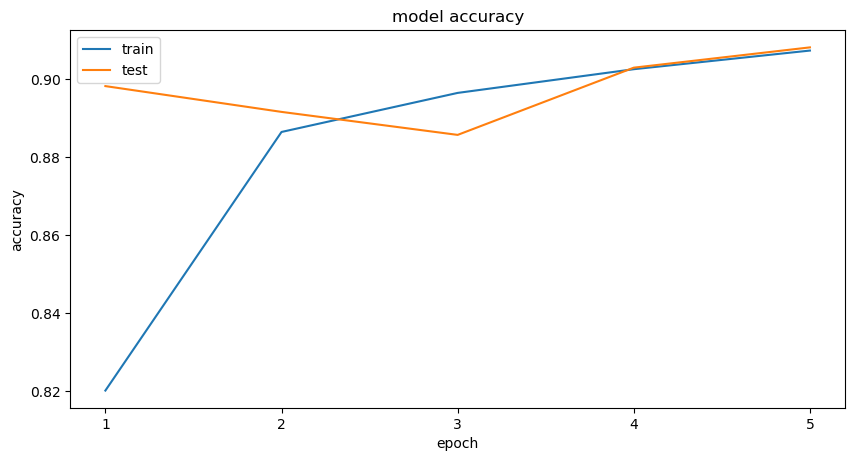

In [28]:
fig = plt.figure(figsize=(10,5), dpi=100, facecolor='white')
plt.plot(np.arange(1,epochs+1),history.history['acc'])
plt.plot(np.arange(1,epochs+1),history.history['val_acc'])
plt.xticks(np.arange(1,epochs+1))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

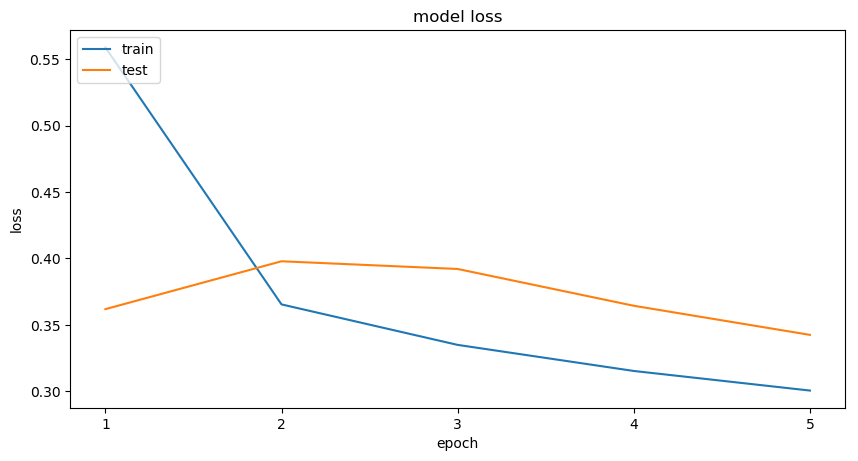

In [29]:
fig = plt.figure(figsize=(10,5), dpi=100, facecolor='white')
plt.plot(np.arange(1,epochs+1),history.history['loss'])
plt.plot(np.arange(1,epochs+1),history.history['val_loss'])
plt.xticks(np.arange(1,epochs+1))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("{}: {:.2f}%".format(model.metrics_names[1], scores[1]*100))

acc: 90.81%


# acc: 90.81% !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [31]:
print('the progress of this jupyter notebook cost: {:.3f} minutes'.format((time.time()-t0)/60))

the progress of this jupyter notebook cost: 43.616 minutes
